In [2]:
import open3d as o3d
import numpy as np
import h5py as h5
from plyfile import PlyData, PlyElement

In [11]:
plydata = PlyData.read("/space/ariyanzarei/sorghum_segmentation/dataset/PointCloud_2022-01-26/0.ply")
print(plydata.elements)
for i in range(len(plydata.elements)):
    print(i,plydata.elements[i].name,plydata.elements[i].data.shape)

(PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('z', 'float'), PlyProperty('y', 'float')), count=80668, comments=[]), PlyElement('color', (PlyProperty('red', 'float'), PlyProperty('green', 'float'), PlyProperty('blue', 'float')), count=80668, comments=[]), PlyElement('leafIndex', (PlyProperty('value', 'int'),), count=80668, comments=[]), PlyElement('leafPartIndex', (PlyProperty('value', 'int'),), count=80668, comments=[]), PlyElement('isMainPlant', (PlyProperty('value', 'int'),), count=80668, comments=[]))
0 vertex (80668,)
1 color (80668,)
2 leafIndex (80668,)
3 leafPartIndex (80668,)
4 isMainPlant (80668,)


In [12]:
import load_raw_data
pcd = load_raw_data.load_pcd_plyfile("/space/ariyanzarei/sorghum_segmentation/dataset/PointCloud_2022-01-26/0.ply")
print(pcd)

{'points': array([[-0.32334656,  0.94224203,  0.65499997],
       [-0.32454979,  0.16783591,  0.72499996],
       [ 0.01454555,  0.49849242,  0.37999997],
       ...,
       [-0.19789091,  0.42477018, -0.47999999],
       [ 0.33650598,  0.89868546, -0.26499999],
       [-0.34890518,  1.09715915, -0.185     ]]), 'leaf_index': array([14,  1,  2, ...,  2,  8, 11]), 'leaf_part_index': array([1, 1, 3, ..., 3, 3, 3]), 'color': array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]]), 'initial_clusters': array([14,  1,  2, ...,  2,  8, 11]), 'affinity_matrix': array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]]), 'is_focal_plant': array([0, 0, 0, ..., 1, 0, 1]), 'samples': array([   0, 5364, 5397, 3452, 4051, 4323, 5940,  934, 

In [13]:
with h5.File("/space/ariyanzarei/sorghum_segmentation/TreePartNetData/tree_labeled_train.hdf5") as f:
    print(f.keys())
    sample_pcd = np.array(f['points'][0])
    # for k in f.keys():
    #     print(k,f[k].shape)
    #     print(f[k][0])
    print('primitive_id',f['primitive_id'].shape)
    prim = np.array(f['primitive_id'])
    lc = np.array(f['lc'])

print(np.min(prim),np.max(prim))
print(np.max(prim,0))
print(np.max(lc,0))

    # print(f['samples'].shape)

<KeysViewHDF5 ['codebook', 'isforks', 'lc', 'names', 'normals', 'points', 'primitive_id', 'samples']>
primitive_id (3521, 8000)
0 80
[80 80 80 ... 80 80 79]
[  0 255 255 ... 255 255 255]


In [3]:
import sys
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib")
from pointnet2_ops.pointnet2_utils import FurthestPointSampling

import torch
import matplotlib.pyplot as plt

/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


In [4]:
furthest_point_sampling = FurthestPointSampling.apply
sample_pcd = torch.Tensor(np.expand_dims(sample_pcd,0)).cuda()
sampled_points = furthest_point_sampling(sample_pcd,256).cpu().data.numpy()
sample_pcd = sample_pcd.cpu().data.numpy()

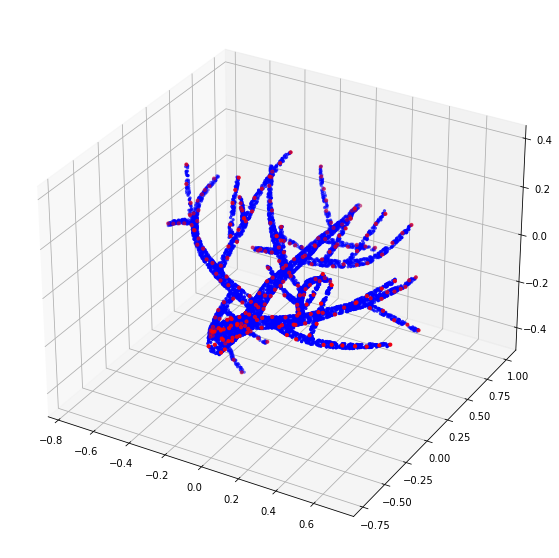

In [5]:
sample_pcd = sample_pcd.squeeze()
sampled_points = sampled_points.squeeze()
new_points = sample_pcd[sampled_points]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(sample_pcd[:,0], sample_pcd[:,1], sample_pcd[:,2], c='blue',s=5)
ax.scatter(new_points[:,0], new_points[:,1], new_points[:,2], c='red',s=10)

In [2]:
from scipy.spatial.distance import cdist
from utils import *

/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


In [7]:


# dist = cdist(sample_pcd,new_points)
# print(np.argmax(dist,1))

ic = get_initial_cluster_assignment(sample_pcd,sampled_points)
print(ic.shape)
print(ic)

(8000,)
[  1   1 117 ...   1   1   2]


In [26]:
import open3d as o3d
import numpy as np
import h5py as h5
from utils import *
import matplotlib.pyplot as plt

with h5.File("/space/ariyanzarei/sorghum_segmentation/SorghumData/sorghum__labeled_train.hdf5") as f:
    points = np.array(f['points'][2])
    labels = np.array(f['leaf_part_index'][2])
print(points.shape)
print(labels.shape)
samples = get_furthest_point_samples(points,16)
print(samples.shape)
ic = get_initial_cluster_assignment(points,samples,labels)    
print(ic.shape)
aff_matrix = get_affinity_matrix(labels,samples)
print(aff_matrix)
is_foc = get_is_focal_plant(labels)
print(is_foc.shape)

(8000, 3)
(8000,)
(16,)
(8000,)
[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.]]
(8000,)


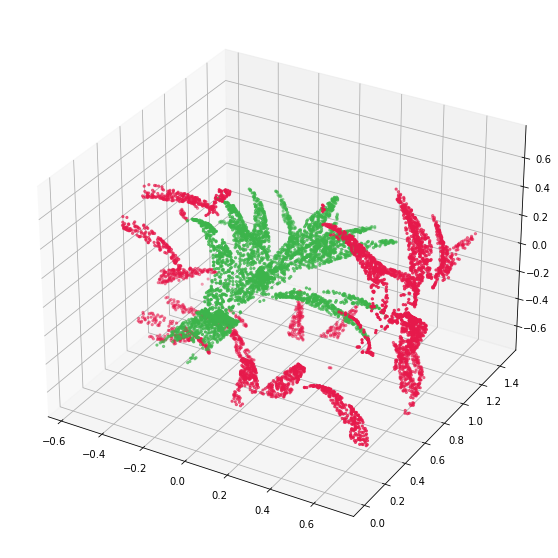

In [29]:
unique_colors = distinct_colors()
colors = np.array([unique_colors[l] for l in ic.squeeze()])
sample_coords = points[samples]
sample_colors = np.array([colors[s] for s in samples])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
# ax.scatter(points[:,0], points[:,1], points[:,2], c=colors,s=1)
# ax.scatter(sample_coords[:,0], sample_coords[:,1], sample_coords[:,2], c=sample_colors,s=100, marker='o')

colors_focal = np.array([unique_colors[int(l)] for l in is_foc.squeeze()])
# # print(colors_focal)
ax.scatter(points[:,0], points[:,1], points[:,2], c=colors_focal,s=5)

In [2]:
from load_raw_data import *
import matplotlib.pyplot as plt
from utils import *
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


[1 1 1 ... 0 1 1]


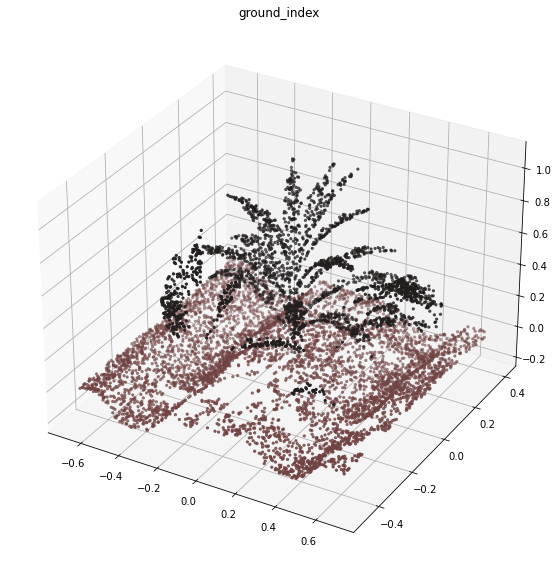

In [3]:
pcd = load_pcd_plyfile("/space/ariyanzarei/sorghum_segmentation/dataset/2022-03-10/PointCloud/0.ply")
for k in pcd.keys():
    if k == "names":
        continue

unique_colors = distinct_colors()

key = 'ground_index'
colors = np.array([unique_colors[int(l)] for l in pcd[key].squeeze()])
points = pcd['points']  
print(pcd[key].squeeze())
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,2], points[:,0], points[:,1], c=colors,s=5)
ax.set_title(key)

pcd = create_ply_pcd_from_points_with_labels(points,pcd[key].squeeze())
# o3d.io.write_point_cloud("/space/ariyanzarei/sorghum_segmentation/dataset/tst/t_3.ply",pcd)

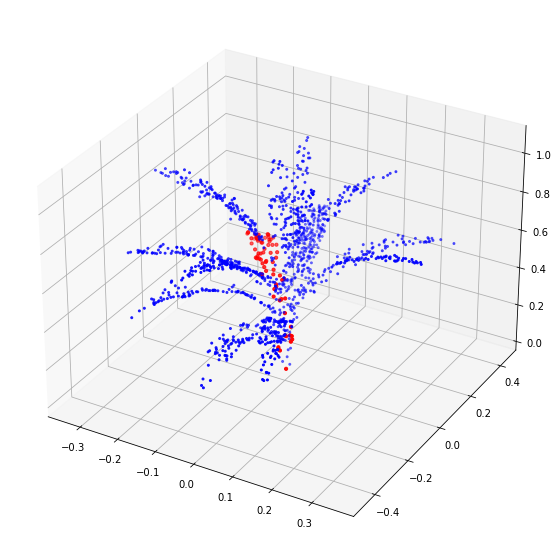

In [84]:
import sys
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet/utils")
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib")
from TreeDataset import SorghumDataset
from load_raw_data import *
import matplotlib.pyplot as plt

ds = SorghumDataset("/space/ariyanzarei/sorghum_segmentation/dataset/2022-03-10/sorghum__labeled_train.hdf5")
points, ground, semantic, plant, leaf = ds[4]

points = points[ground==0]
leaf = leaf[ground==0]
plant = plant[ground==0]

min_plant_index = torch.min(plant)
max_plant_index = torch.max(plant)
min_leaf_index = torch.min(leaf)
max_leaf_index = torch.max(leaf)

for pl in range(min_plant_index,max_plant_index+1):
    # for i in range(5):
    #     leaves = random.sample(range(min_leaf_index,max_leaf_index+1),2)
    #     leaf_1 = leaves[0]
    #     leaf_2 = leaves[1]
            
    #     criteria = ((leaf==leaf_1) | (leaf==leaf_2))
    #     not_criteria = ((leaf!=leaf_1) & (leaf!=leaf_2))
        
    #     points_org = points[(not_criteria) & (plant == pl),:]

    #     fig = plt.figure(figsize=(10,10))
    #     ax = fig.add_subplot(projection='3d')
    #     ax.scatter(points_org[:,0], points_org[:,2], points_org[:,1], c='blue',s=4)

    #     points_leaf = points[(criteria) & (plant == pl),:]

    #     mins_leafs,_ = torch.min(points_leaf,axis=0)
    #     maxs_leafs,_ = torch.max(points_leaf,axis=0)
        
    #     for j in range(5):
    #         sampled_min_x = random.uniform(mins_leafs[0],mins_leafs[0]+(maxs_leafs[0]-mins_leafs[0])/6)
    #         sampled_max_x = random.uniform(maxs_leafs[0]-(maxs_leafs[0]-mins_leafs[0])/6,maxs_leafs[0])

    #         sampled_min_y = random.uniform(mins_leafs[1],mins_leafs[1]+(maxs_leafs[1]-mins_leafs[1])/6)
    #         sampled_max_y = random.uniform(maxs_leafs[1]-(maxs_leafs[1]-mins_leafs[1])/6,maxs_leafs[1])

    #         sampled_min_z = random.uniform(mins_leafs[2],mins_leafs[2]+(maxs_leafs[2]-mins_leafs[2])/6)
    #         sampled_max_z = random.uniform(maxs_leafs[2]-(maxs_leafs[2]-mins_leafs[2])/6,maxs_leafs[2])

    #         points_subleaf = points_leaf[(points_leaf[:,0]>=sampled_min_x)&(points_leaf[:,0]<=sampled_max_x)&
    #                                     (points_leaf[:,1]>=sampled_min_y)&(points_leaf[:,1]<=sampled_max_y)&
    #                                     (points_leaf[:,2]>=sampled_min_z)&(points_leaf[:,2]<=sampled_max_z),:]

    #         ax.scatter(points_subleaf[:,0], points_subleaf[:,2], points_subleaf[:,1], c='red',s=10)
    #         break
    #     break
    
    for lf in range(min_leaf_index+1,max_leaf_index+1):
        criteria = (leaf==lf)
        not_criteria = (leaf!=lf)
        
        points_org = points[(not_criteria) & (plant == pl),:]

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(points_org[:,0], points_org[:,2], points_org[:,1], c='blue',s=4)

        points_leaf = points[(criteria) & (plant == pl),:]

        ax.scatter(points_leaf[:,0], points_leaf[:,2], points_leaf[:,1], c='red',s=10)
        break
    break

In [1]:
import sys
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet/utils")
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib")
from TreeDataset import TreeDataset, SorghumDataset
from load_raw_data import *
import matplotlib.pyplot as plt

# ds = TreeDataset("/space/ariyanzarei/sorghum_segmentation/dataset/2022-01-28/sorghum__labeled_train.hdf5")
ds = SorghumDataset("/space/ariyanzarei/sorghum_segmentation/dataset/2022-01-28/sorghum__labeled_train.hdf5")

points, _,leaf,part,_= ds[1:23]
print(points.shape)

# leaf = torch.unsqueeze(leaf.float(),dim=-1)
# distances_gt = torch.cdist(leaf,leaf)
# normalized_distance_gt = torch.where(distances_gt==0,1,-1)
# print(normalized_distance_gt)

/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
torch.Size([22, 8000, 3])


/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib/pointnet2_ops/pointnet2_utils.py:15: UserWarning: Unable to load pointnet2_ops cpp extension. JIT Compiling.
  warnings.warn("Unable to load pointnet2_ops cpp extension. JIT Compiling.")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
points torch.Size([8000, 3]) tensor([1243, 5825,  556]) tensor([3758,  641,  365])
ground torch.Size([8000]) [0.0, 1.0]
semantic torch.Size([8000]) [0, 1, 2]
plant torch.Size([8000]) [0, 1, 2, 3, 4, 5]
leaf torch.Size([8000]) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
--------------------------
points torch.Size([1600, 3]) tensor([ 638, 1198, 1047]) tensor([1008,  139, 1413])
ground torch.Size([8000]) [0.0, 1.0]
semantic torch.Size([8000]) [0, 1, 2]
plant torch.Size([1600]) [0]
leaf torch.Size([1600]) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
--------------------------


Text(0.5, 0.92, 'plant')

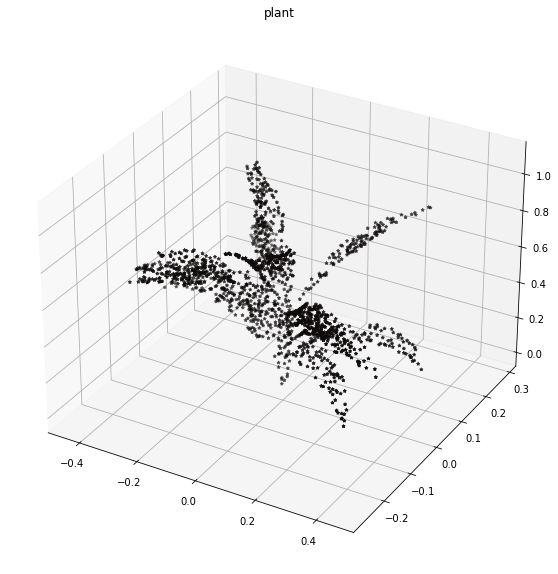

In [1]:
import sys
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet/utils")
sys.path.append("/work/ariyanzarei/SorghumSegmentation/TreePartNet/pointnet2_ops_lib")
from TreeDataset import TreeDataset, SorghumDataset
from load_raw_data import *
import matplotlib.pyplot as plt

ds = SorghumDataset("/space/ariyanzarei/sorghum_segmentation/dataset/2022-03-10/sorghum__labeled_train.hdf5")
points, ground, semantic, plant, leaf = ds[0]
pcd = {
    "points": points,
    "ground": ground,
    "semantic": semantic,
    "plant": plant,
    "leaf": leaf
}

# plant_ind = list(set(list(plant.cpu().numpy())))
# ind = list(range(0,len(plant_ind)))
# mapping = dict(zip(ind,plant_ind))
# new_plant = torch.zeros(plant.shape)
# for key in mapping:
#     new_plant[plant==mapping[key]] = key
# plant = new_plant

print("points", points.shape, torch.min(points,axis=0)[1], torch.max(points,axis=0)[1])
print("ground", ground.shape,list(set(list(ground.cpu().numpy()))))
print("semantic", semantic.shape, list(set(list(semantic.cpu().numpy()))))
print("plant", plant.shape,list(set(list(plant.cpu().numpy()))))
print("leaf", leaf.shape,list(set(list(leaf.cpu().numpy()))))

print("--------------------------")

points = points[semantic==1]
plant = plant[semantic==1]
leaf = leaf[semantic==1]
key = "plant"
labeling_set = pcd[key][semantic==1]

print("points", points.shape, torch.min(points,axis=0)[1], torch.max(points,axis=0)[1])
print("ground", ground.shape,list(set(list(ground.cpu().numpy()))))
print("semantic", semantic.shape, list(set(list(semantic.cpu().numpy()))))
print("plant", plant.shape,list(set(list(plant.cpu().numpy()))))
print("leaf", leaf.shape,list(set(list(leaf.cpu().numpy()))))

print("--------------------------")

unique_colors = distinct_colors()
colors = np.array([unique_colors[int(l)] for l in labeling_set.squeeze()])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,2], points[:,0], points[:,1], c=colors,s=10,marker='*')
ax.set_title(key)

points (20000, 3) [-0.57246673 -0.17832409 -0.68000007] [0.63196194 1.09423089 0.70500004]
ground (20000,) [0, 1]
plant (20000,) [0, 1, 2, 5, 7]
leaf (20000,) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
--------------------------
points (4332, 3) [-0.56982672  0.00805594 -0.68000001] [0.63184392 1.09423089 0.70500004]
ground (20000,) [0, 1]
plant (4332,) [0, 1, 2, 5, 7]
leaf (4332,) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
--------------------------


Text(0.5, 0.92, 'plant_index')

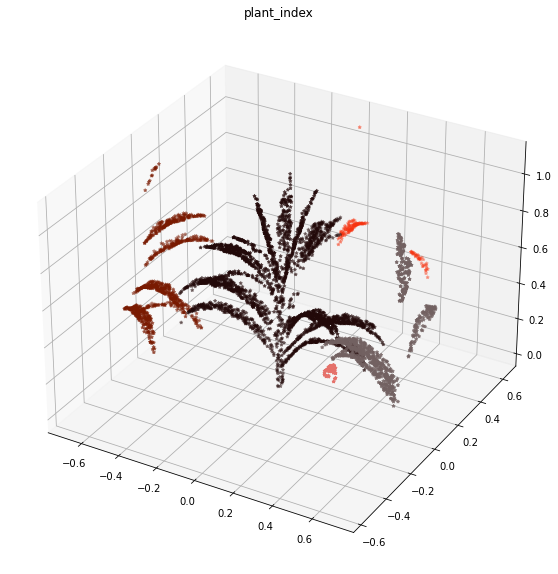

In [9]:

pcd = load_pcd_plyfile("/space/ariyanzarei/sorghum_segmentation/dataset/2022-03-10/PointCloud/25.ply",down_sample_n=20000)
points = pcd['points']
ground = pcd['ground_index']
plant = pcd['plant_index']
leaf = pcd['leaf_index']

print("points", points.shape, np.min(points,axis=0), np.max(points,axis=0))
print("ground", ground.shape,list(set(list(ground))))
print("plant", plant.shape,list(set(list(plant))))
print("leaf", leaf.shape,list(set(list(leaf))))

print("--------------------------")

points = points[ground==0]
plant = plant[ground==0]
leaf = leaf[ground==0]
key = "plant_index"
labeling_set = pcd[key][ground==0]

print("points", points.shape, np.min(points,axis=0), np.max(points,axis=0))
print("ground", ground.shape,list(set(list(ground))))
print("plant", plant.shape,list(set(list(plant))))
print("leaf", leaf.shape,list(set(list(leaf))))

print("--------------------------")


unique_colors = distinct_colors()
colors = np.array([unique_colors[int(l)] for l in labeling_set.squeeze()])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,2], points[:,0], points[:,1], c=colors,s=10,marker='*')
ax.set_title(key)